## Homework 6, Problem 3 on Wiener filter

ECE C143A/C243A, Spring Quarter 2023, Prof. J.C. Kao, TAs T. Monsoor, R. Gore, D. Singla

Total: 15 points. In this notebook, you will implement an optimal linear estimator decoder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.io as sio
import math
import nsp as nsp
# Load matplotlib images inline
%matplotlib inline
# Reloading any code written in external .py files.
%load_ext autoreload
%autoreload 2
data = sio.loadmat('JR_2015-12-04_truncated2.mat') # load the .mat file.
R = data['R'][0,:]

### (a) (4 points) Preparing training data for a Wiener filter.  [Code solution provided; please understand it and answer the question.]

Now that we’ve built an optimal linear estimator, we’ll extend it to incorporate history. We will train a Wiener filter, again using just the first 400 trials of the R-struct. We will use 100 ms worth of history in our Wiener filter. As each bin is 25 ms long, this corresponds to using data up to and including 4 bins in the past, i.e. $P=3$. Make the large matrix $Y_W$ discussed in Lecture. To be clear, we are talking about the matrix:
\begin{bmatrix}
    y_{P+1}       & y_{P+2} & y_{P+3} & \dots & y_{K} \\
    y_{P}       & y_{P+1} & y_{P+2} & \dots & y_{K-1} \\
    \dots \\
    y_{1}       & y_{2} & y_{3} & \dots & y_{K-P}\\
    1       & 1 & 1 & \dots & 1\\
\end{bmatrix}
Calculate this matrix and output its dimension.

In [4]:
#====================================================#
# YOUR CODE HERE:
#   Create the Y_W matrix and print its dimensions.
#====================================================#
dt = 25
train_num = 400
Y =scipy.sparse.hstack(R[0:train_num]['spikeRaster'])
X =scipy.sparse.hstack(R[0:train_num]['cursorPos'])
X= scipy.sparse.csc_matrix(X)
Y_bin = nsp.bin(Y, dt,'sum')

X_bin = nsp.bin(X, dt,'first')
X_bin = np.diff(X_bin[0:2,:])/dt*1000

X_small_bin = np.matrix(X_bin[:,3:],dtype=float)
last_index = np.size(X_bin,1)
Y1= np.matrix(Y_bin[:,3:],dtype= float)
Y2 =np.matrix(Y_bin[:,2:-1],dtype= float)
Y3 =np.matrix(Y_bin[:,1:-2],dtype= float)
Y4 =np.matrix(Y_bin[:,0:-3],dtype= float)
Y_large = np.vstack((Y1,Y2,Y3,Y4))

Y_w_bin = np.vstack((Y_large,np.ones(np.size(Y_large,1))))

print("The dimension for the large matrix",np.size(Y_w_bin,0),np.size(Y_w_bin,1))
#====================================================#
# END YOUR CODE
#====================================================#   

The dimension for the large matrix 385 16462


Question: What are the dimensions of $Y_W$?

Answer: 385 by 16462.

385 = 96 * 4 + 1

### (b) (7 points)  Fit a Wiener filter and decode activity.

Fit the Wiener filter using the data matrix you generated in part(a). Plot, as you did in question 2(g), the decoded trajectories for each test trial. (Hint: to decode the first 3 velocities of trial i at times 25 ms, 50 ms, and 75 ms, since 100 ms have not yet occurred in the trial, you will have to use the last bins of spiking activity in trial $i−1$.)


[[  12.08         13.5605577    15.91482802   18.66403228   20.25315391
    19.60803631   19.65422215   17.75684882   15.73937957   15.31044461
    14.00350422   15.58540651   16.70971543   15.62081126   14.56726649
    13.18625342   13.58694666   15.35803299   17.151626     18.23799799
    18.57937661   19.51077504   20.62437689   22.24765117   21.31246714
    21.85598788   20.22018702   19.52124554   18.92225582   18.37626775
    19.28113777   19.76648609   20.34892195   21.07775385   21.14561749
    22.18174228   22.98205652   25.14611511   26.93658529]
 [-124.38       -123.07618847 -121.97524964 -119.8127293  -118.9115052
  -119.22024985 -119.71039368 -123.6727862  -126.91271249 -130.33669722
  -131.89952634 -132.4030854  -131.29717806 -129.70547172 -125.57000307
  -121.61339609 -116.69226746 -112.68165943 -111.24446692 -112.25575601
  -113.11786881 -117.26715794 -119.07267113 -121.04419291 -120.26963315
  -118.7536336  -117.24644676 -116.44252423 -117.75797705 -118.15617606
  -117

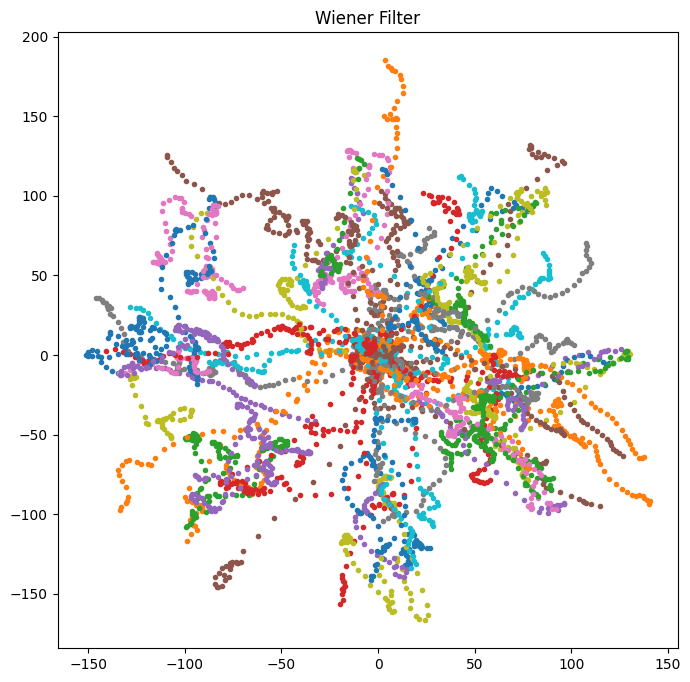

In [11]:
#====================================================#
# YOUR CODE HERE:
#   Fit the Wiener filter and decode the trajectories for
#   each test trial.
#====================================================#
plt.figure(figsize=(8,8))

L = np.matmul(X_bin[:,3:].astype('float'),scipy.linalg.pinv(Y_w_bin.astype('float')))

overall = list()

for i in range(400,506):
    Y_bin = nsp.bin(R[i]['spikeRaster'], dt,'sum')
    Y1_bin = nsp.bin(R[i-1]['spikeRaster'], dt,'sum')
    
    Y1 = np.matrix(Y_bin,dtype= float)
    Y2 = np.matrix(Y_bin[:,:-1],dtype= float)
    Y3 = np.matrix(Y_bin[:,:-2],dtype= float)
    Y4 = np.matrix(Y_bin[:,:-3],dtype= float)
    
    Y21 = np.matrix(Y1_bin[:,-1:],dtype= float)
    Y31 = np.matrix(Y1_bin[:,-2:],dtype= float)
    Y41 = np.matrix(Y1_bin[:,-3:],dtype= float)
    
    Y2 = np.hstack((Y21,Y2))
    Y3 = np.hstack((Y31,Y3))
    Y4 = np.hstack((Y41,Y4))
    
    Y5 = np.vstack((Y1,Y2,Y3,Y4))
    Y_bin = np.vstack((Y5,np.ones(np.size(Y5,1))))
    
    Xi = np.array(np.matmul(L,Y_bin))
    weiner = np.zeros([2, Xi.shape[1]+1])
    weiner[:,0] = R[i]['cursorPos'][:2,0]
    for j in range(Xi.shape[1]):
        weiner[:,j+1] = weiner[:,j] + Xi[:,j]*0.025
    plt.plot(weiner[0,:],weiner[1,:],'.')  
    overall.append(weiner)
    
plt.title('Wiener Filter')
print((overall[0]))
#====================================================#
# END YOUR CODE
#====================================================#   

### (c) (4 points) Calculate the mean-square error for the Wiener filter.

What is the average mean-square error in position per trial? Did the Wiener filter perform better or worse than the optimal linear estimator?

In [13]:
#====================================================#
# YOUR CODE HERE:
#   Calculate the mean-squared error between the decoded
#   hand position and the true hand position.  Average
#   the squared errors across time; then average the squared
#   errors across trials.
#====================================================#
error = np.zeros(106)

for trial in np.arange(400,506):
    
    # true hand position
    posTrue = R[trial]['cursorPos'][0:2,:]
    posTrue = posTrue[:, np.arange(0, np.size(posTrue, 1), dt)]

    # decoded hand position
    posDecoded = overall[trial - 506]
    
    difference = posTrue[:, np.arange(np.minimum(np.size(posTrue, 1), np.size(posDecoded, 1)))] - posDecoded[:,np.arange(np.minimum(np.size(posTrue, 1), np.size(posDecoded, 1)))]
    
    error[trial - train_num] = np.sum(np.power(difference, 2), 0).mean()
    
meanSqError = np.mean(error)
print(meanSqError)
#====================================================#
# END YOUR CODE
#====================================================#  

3254.3106085322925


Question: Does the WF do better or worse than the OLE?

Answer: The WF does better than the OLE. The mean squared error of the OLE is approximately 5326, and this is 3254.